In [1]:
import utils as utils
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
DATA_FILE_PATH = 'data.json'

In [3]:
train_tups, test_tups = utils.split_data(utils.generate_tuples_from_file(DATA_FILE_PATH, num_samples=10000), test_size=0.2)

print('Training set size: ', len(train_tups[0]))
print('Test set size: ', len(test_tups[0]))
print('Sample tokenized review: ', train_tups[0][0])
print('Sample rating: ', train_tups[1][0])

Training set size:  8000
Test set size:  2000
Sample tokenized review:  ['If', 'you', 'are', 'hip', 'and', 'into', 'Mid-Century', 'Modern', 'goods', '-', 'and', 'being', 'green', ',', 'you', 'have', 'to', 'check', 'out', 'TFA', '.', 'It', 'is', 'like', 'a', 'big', 'ball', 'of', 'Mid-Century', 'Furniture', ',', 'Clothing', ',', 'Jewelry', 'and', 'what-cha-ma-call-its', 'all', 'in', 'one', 'place', '.', 'It', 'is', 'a', 'great', 'place', 'if', 'you', 'are', 'looking', 'for', 'that', 'truly', 'unique', 'gift', '.', 'We', 'have', 'purchased', 'several', 'items', 'and', 'we', 'love', 'visiting', '!', 'They', 'are', 'super', 'nice', 'and', 'very', 'helpful', '.', 'It', "'s", 'too', 'bad', 'my', 'friends', 'in', 'Cali', 'ca', "n't", 'enjoy', 'this', 'place', '-', 'they', 'would', 'eat', 'it', 'up', '.']
Sample rating:  5


In [4]:
# implement FFNN with doc2vec embeddings as input

tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tups[0])]
d2v_model = Doc2Vec(tagged_docs, vector_size=100, window=2, min_count=1, workers=4)

vectors = [d2v_model.dv[i] for i in range(len(tagged_docs))]

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.metrics import Recall, Precision, F1Score

input_dim = 100

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_dim,)))  
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))


# put in an output layer
model.add(Dense(5, activation='softmax'))

model.summary()
sgd = SGD(learning_rate=.01)
recall = Recall()
precision = Precision()
f1_score = F1Score()

# call compile here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1_score])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 15405 (60.18 KB)
Trainable params: 15405 (60.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
import tensorflow as tf
import numpy as np

# Convert input data to NumPy arrays
vectors_np = np.array(vectors)
train_tups_np = train_tups[1]
train_tups_np = utils.get_one_hot_encodings(train_tups_np)

# Create a tf.data.Dataset from the input and output vectors
dataset = tf.data.Dataset.from_tensor_slices((vectors_np, train_tups_np))

# Repeat the dataset indefinitely
dataset = dataset.repeat()

# Batch the data
batch_size=500
dataset = dataset.batch(batch_size)

# Fit the model
steps_per_epoch = len(vectors_np) // batch_size
history = model.fit(dataset, epochs=20, batch_size=500, steps_per_epoch=steps_per_epoch)

Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 1.4765 - accuracy: 0.3780 - recall: 0.0480 - precision: 0.3582 - f1_score: 0.1438

16/16 [==============================] - 0s 7ms/step - loss: 1.3887 - accuracy: 0.4359 - recall: 0.1146 - precision: 0.5413 - f1_score: 0.1796
Epoch 2/20
16/16 [==============================] - 0s 7ms/step - loss: 1.3213 - accuracy: 0.4520 - recall: 0.1596 - precision: 0.6098 - f1_score: 0.2159
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 1.2773 - accuracy: 0.4746 - recall: 0.2071 - precision: 0.6236 - f1_score: 0.2516
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 1.2405 - accuracy: 0.4865 - recall: 0.2371 - precision: 0.6441 - f1_score: 0.2814
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 1.2153 - accuracy: 0.4895 - recall: 0.2636 - precision: 0.6544 - f1_score: 0.2938
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 1.1930 - accuracy: 0.4994 - recall: 0.2777 - precision: 0.6637 - f1_score: 0.3148
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 1.1789 - accur

In [9]:
review_to_predict = "The food was awful."
vectors_np = np.array([d2v_model.infer_vector(review_to_predict.split(' '))])
prob_distribution = model.predict(vectors_np)

print('Predicted rating: ', np.argmax(prob_distribution) + 1)

1/1 [==============================] - 0s 34ms/step
Predicted rating:  1


In [10]:
review_to_predict = "The waiter was nice. The food was warm and delicious. I would definitely come back again."
vectors_np = np.array([d2v_model.infer_vector(review_to_predict.split(' '))])
prob_distribution = model.predict(vectors_np)

print('Predicted rating: ', np.argmax(prob_distribution) + 1)



1/1 [==============================] - 0s 55ms/step
Predicted rating:  5


20


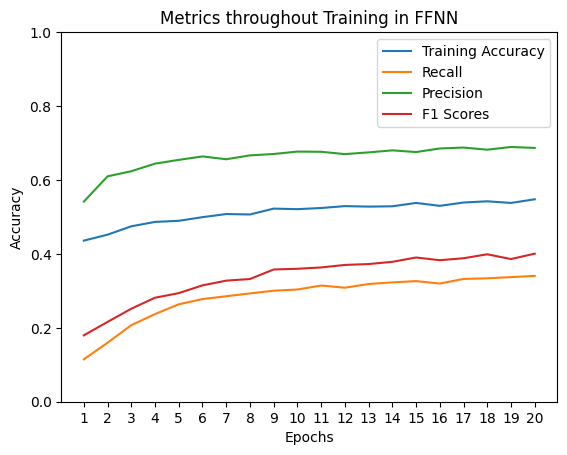

In [26]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
f1_scores = history.history['f1_score']
recall_scores = history.history['recall']
precisions = history.history['precision']

averagedF1ScoresList = []
for f1_score_list in f1_scores:
    average = sum(f1_score_list)/5
    averagedF1ScoresList.append(average)

print(len(averagedF1ScoresList))


epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, recall_scores, label='Recall')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, averagedF1ScoresList, label='F1 Scores')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Metrics throughout Training in FFNN')
plt.xticks(range(1,21,1))
plt.legend()
plt.show()